/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80385D+00    |proj g|=  1.18154D-01


 This problem is unconstrained.



At iterate    5    f=  1.78027D+00    |proj g|=  4.09259D-02

At iterate   10    f=  1.75521D+00    |proj g|=  2.16896D-02

At iterate   15    f=  1.75492D+00    |proj g|=  2.18059D-03

At iterate   20    f=  1.75491D+00    |proj g|=  2.72170D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     26      1     0     0   9.858D-06   1.755D+00
  F =   1.7549111727380966     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                                       
Dep. Variable:                Contagios_transformed   No. Observations:           

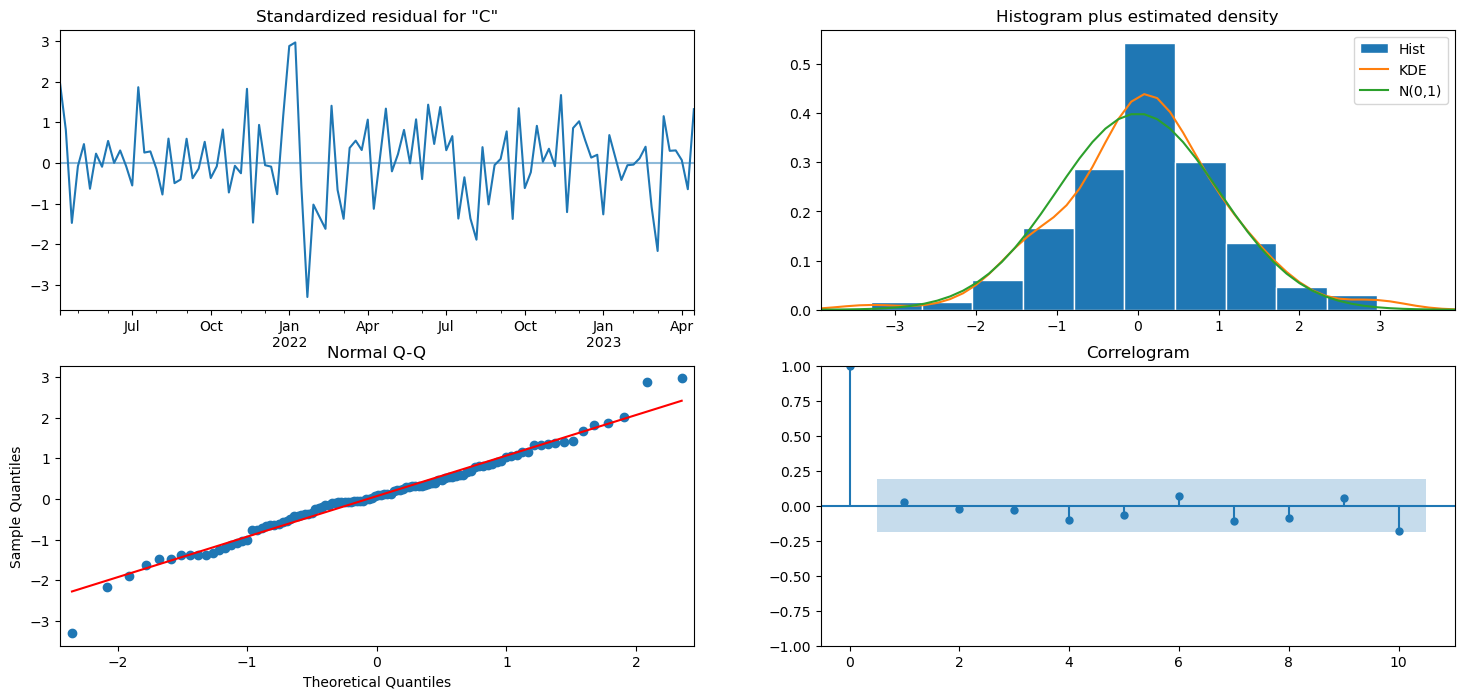

In [2]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from matplotlib import pyplot as plt
import plotly.graph_objects as go

def cargar_datos_cluster(ruta_csv, cluster_id):
    # Leer el archivo CSV
    df = pd.read_csv(ruta_csv)
    
    # Configurar la primera columna ('Cluster') como índice
    df.set_index('Cluster', inplace=True)
    
    # Transponer el dataframe para que las fechas sean el índice
    df = df.transpose()
    
    # Filtrar los datos para el cluster específico
    cluster_data = df[cluster_id]
    
    # Resetear el índice para que las fechas sean una columna y no el índice
    cluster_data = cluster_data.reset_index()
    
    # Cambiar los nombres de las columnas
    cluster_data.columns = ['Fecha', 'Contagios']
    
    # Convertir la columna de fecha a tipo datetime para manejarlo como serie temporal
    cluster_data['Fecha'] = pd.to_datetime(cluster_data['Fecha'], format='%d-%m-%Y')
    
    # Establecer la fecha como índice
    cluster_data.set_index('Fecha', inplace=True)
    
    return cluster_data


# Ruta del archivo CSV
ruta_csv = 'clusterSemanal.csv'
# ID del cluster que el usuario quiere explorar
cluster_id = 0

# Cargar los datos
df_pacientesRespiratorios = cargar_datos_cluster(ruta_csv, cluster_id)

# Asegurarse de que no hay valores no positivos antes de la transformación Box-Cox
df_pacientesRespiratorios['Contagios'] = df_pacientesRespiratorios['Contagios'].clip(lower=1)

# Aplicar transformación Box-Cox
df_pacientesRespiratorios['Contagios_transformed'], lambda_ = boxcox(df_pacientesRespiratorios['Contagios'])

# Dividir los datos transformados en entrenamiento y prueba
train_data_transformed = df_pacientesRespiratorios['Contagios_transformed'].iloc[:-10]
test_data = df_pacientesRespiratorios.iloc[-10:]

p = 1
d = 2
q = 3
P = 1
D = 1
Q = 1
S = 30  # asumiendo una estacionalidad semanal

# Ajuste del modelo SARIMA con los datos de entrenamiento transformados
model = SARIMAX(train_data_transformed,
                order=(p, d, q),
                seasonal_order=(P, D, Q, S),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Diagnósticos del modelo y resultados de resumen
print(results.summary())
results.plot_diagnostics(figsize=(18, 8))
plt.show()

# Hacer predicciones para el conjunto de prueba y revertir la transformación Box-Cox
pred_uc = results.get_forecast(steps=10)
predicted_mean_transformed = pred_uc.predicted_mean
predicted_mean = inv_boxcox(predicted_mean_transformed, lambda_)
predicted_mean.index = test_data.index  # Asignar directamente el índice del conjunto de prueba
pred_ci_transformed = pred_uc.conf_int()
pred_ci = pd.DataFrame()
pred_ci['lower'] = inv_boxcox(pred_ci_transformed.iloc[:, 0], lambda_)
pred_ci['upper'] = inv_boxcox(pred_ci_transformed.iloc[:, 1], lambda_)



# Calcular el error absoluto
error_absoluto = abs(test_data['Contagios'] - predicted_mean)

fig = go.Figure()

# Agregar los datos observados como una serie de líneas con puntos
fig.add_trace(go.Scatter(x=df_pacientesRespiratorios.index, y=df_pacientesRespiratorios['Contagios'], mode='lines+markers', name='Observado'))

# Agregar las predicciones como otra serie de líneas con puntos
fig.add_trace(go.Scatter(x=predicted_mean.index, y=predicted_mean, mode='lines+markers', name='Pronóstico'))

# Agregar el intervalo de confianza como un área sombreada
fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 0], fill=None, mode='lines', line=dict(color='lightgrey'), showlegend=False))
fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 1], fill='tonexty', mode='lines', line=dict(color='lightgrey'), showlegend=False))

# Agregar los datos reales de prueba como una línea discontinua con puntos
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Contagios'], mode='lines+markers', name='Real', line=dict(dash='dash')))

# Agregar el error absoluto como una nueva serie de barras
fig.add_trace(go.Bar(x=test_data.index, y=error_absoluto, name='Error Absoluto'))

# Actualizar el diseño de la gráfica para añadir títulos y etiquetas
fig.update_layout(title='Contagios Observados, Pronósticos y Error Absoluto',
                  xaxis_title='Fecha',
                  yaxis_title='Contagios',
                  legend_title='Leyenda')

# Mostrar la figura
fig.show()

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85563D+00    |proj g|=  1.19771D-01


 This problem is unconstrained.



At iterate    5    f=  1.83151D+00    |proj g|=  3.03036D-02

At iterate   10    f=  1.80838D+00    |proj g|=  9.31003D-03

At iterate   15    f=  1.80759D+00    |proj g|=  1.66974D-02

At iterate   20    f=  1.80491D+00    |proj g|=  1.80058D-02

At iterate   25    f=  1.79811D+00    |proj g|=  9.16788D-01

At iterate   30    f=  1.78686D+00    |proj g|=  6.56313D-02

At iterate   35    f=  1.78660D+00    |proj g|=  2.33195D-02

At iterate   40    f=  1.78641D+00    |proj g|=  2.61225D-02

At iterate   45    f=  1.78636D+00    |proj g|=  8.94163D-03

At iterate   50    f=  1.78636D+00    |proj g|=  3.16945D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                       
Dep. Variable:                Contagios_transformed   No. Observations:                  172
Model:             SARIMAX(1, 2, 5)x(1, 1, [1], 30)   Log Likelihood                -307.254
Date:                              Thu, 18 Apr 2024   AIC                            632.508
Time:                                      15:31:37   BIC                            656.308
Sample:                                  01-05-2020   HQIC                           642.150
                                       - 04-16-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7855      0.108      7.263      0.000       0.574       0.997
ma.L1         -1.40

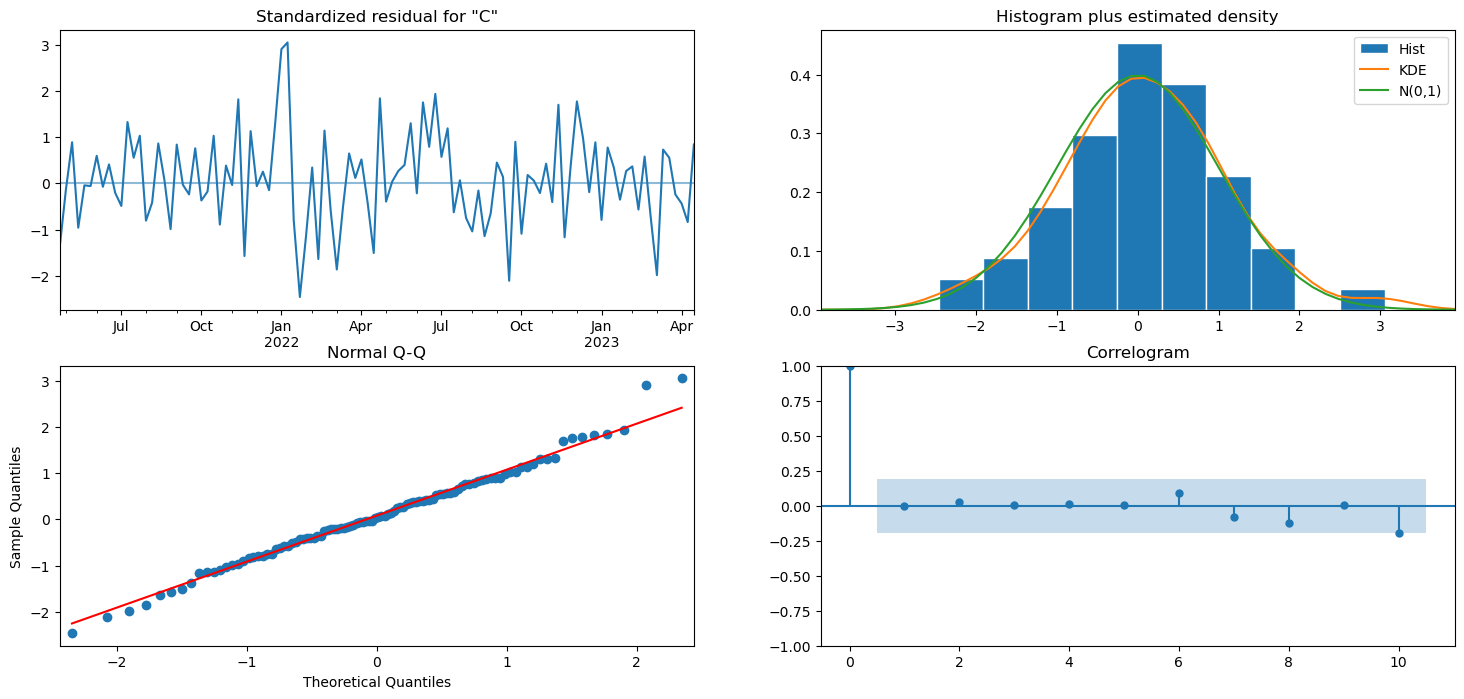

In [23]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from matplotlib import pyplot as plt
import plotly.graph_objects as go

def cargar_datos_cluster(ruta_csv, cluster_id):
    # Leer el archivo CSV
    df = pd.read_csv(ruta_csv)
    
    # Configurar la primera columna ('Cluster') como índice
    df.set_index('Cluster', inplace=True)
    
    # Transponer el dataframe para que las fechas sean el índice
    df = df.transpose()
    
    # Filtrar los datos para el cluster específico
    cluster_data = df[cluster_id]
    
    # Resetear el índice para que las fechas sean una columna y no el índice
    cluster_data = cluster_data.reset_index()
    
    # Cambiar los nombres de las columnas
    cluster_data.columns = ['Fecha', 'Contagios']
    
    # Convertir la columna de fecha a tipo datetime para manejarlo como serie temporal
    cluster_data['Fecha'] = pd.to_datetime(cluster_data['Fecha'], format='%d-%m-%Y')
    
    # Establecer la fecha como índice
    cluster_data.set_index('Fecha', inplace=True)
    
    return cluster_data


# Ruta del archivo CSV
ruta_csv = 'clusterSemanal.csv'
# ID del cluster que el usuario quiere explorar
cluster_id = 1

# Cargar los datos
df_pacientesRespiratorios = cargar_datos_cluster(ruta_csv, cluster_id)

# Asegurarse de que no hay valores no positivos antes de la transformación Box-Cox
df_pacientesRespiratorios['Contagios'] = df_pacientesRespiratorios['Contagios'].clip(lower=1)

# Aplicar transformación Box-Cox
df_pacientesRespiratorios['Contagios_transformed'], lambda_ = boxcox(df_pacientesRespiratorios['Contagios'])

# Dividir los datos transformados en entrenamiento y prueba
train_data_transformed = df_pacientesRespiratorios['Contagios_transformed'].iloc[:-10]
test_data = df_pacientesRespiratorios.iloc[-10:]

p = 1
d = 2
q = 5
P = 1
D = 1
Q = 1
S = 30  # asumiendo una estacionalidad semanal

# Ajuste del modelo SARIMA con los datos de entrenamiento transformados
model = SARIMAX(train_data_transformed,
                order=(p, d, q),
                seasonal_order=(P, D, Q, S),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Diagnósticos del modelo y resultados de resumen
print(results.summary())
results.plot_diagnostics(figsize=(18, 8))
plt.show()

# Hacer predicciones para el conjunto de prueba y revertir la transformación Box-Cox
pred_uc = results.get_forecast(steps=10)
predicted_mean_transformed = pred_uc.predicted_mean
predicted_mean = inv_boxcox(predicted_mean_transformed, lambda_)
predicted_mean.index = test_data.index  # Asignar directamente el índice del conjunto de prueba
pred_ci_transformed = pred_uc.conf_int()
pred_ci = pd.DataFrame()
pred_ci['lower'] = inv_boxcox(pred_ci_transformed.iloc[:, 0], lambda_)
pred_ci['upper'] = inv_boxcox(pred_ci_transformed.iloc[:, 1], lambda_)



# Calcular el error absoluto
error_absoluto = abs(test_data['Contagios'] - predicted_mean)

fig = go.Figure()

# Agregar los datos observados como una serie de líneas con puntos
fig.add_trace(go.Scatter(x=df_pacientesRespiratorios.index, y=df_pacientesRespiratorios['Contagios'], mode='lines+markers', name='Observado'))

# Agregar las predicciones como otra serie de líneas con puntos
fig.add_trace(go.Scatter(x=predicted_mean.index, y=predicted_mean, mode='lines+markers', name='Pronóstico'))

# Agregar el intervalo de confianza como un área sombreada
fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 0], fill=None, mode='lines', line=dict(color='lightgrey'), showlegend=False))
fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 1], fill='tonexty', mode='lines', line=dict(color='lightgrey'), showlegend=False))

# Agregar los datos reales de prueba como una línea discontinua con puntos
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Contagios'], mode='lines+markers', name='Real', line=dict(dash='dash')))

# Agregar el error absoluto como una nueva serie de barras
fig.add_trace(go.Bar(x=test_data.index, y=error_absoluto, name='Error Absoluto'))

# Actualizar el diseño de la gráfica para añadir títulos y etiquetas
fig.update_layout(title='Contagios Observados, Pronósticos y Error Absoluto',
                  xaxis_title='Fecha',
                  yaxis_title='Contagios',
                  legend_title='Leyenda')

# Mostrar la figura
fig.show()

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77623D+00    |proj g|=  7.52040D-02


 This problem is unconstrained.



At iterate    5    f=  1.75107D+00    |proj g|=  2.75214D-02

At iterate   10    f=  1.73728D+00    |proj g|=  6.49836D-03

At iterate   15    f=  1.73694D+00    |proj g|=  2.26166D-03

At iterate   20    f=  1.73494D+00    |proj g|=  3.32089D-02

At iterate   25    f=  1.73187D+00    |proj g|=  1.86925D-02

At iterate   30    f=  1.73142D+00    |proj g|=  2.08842D-03

At iterate   35    f=  1.73141D+00    |proj g|=  9.28399D-05

At iterate   40    f=  1.73141D+00    |proj g|=  1.20564D-04

At iterate   45    f=  1.73141D+00    |proj g|=  9.84693D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     49     59   

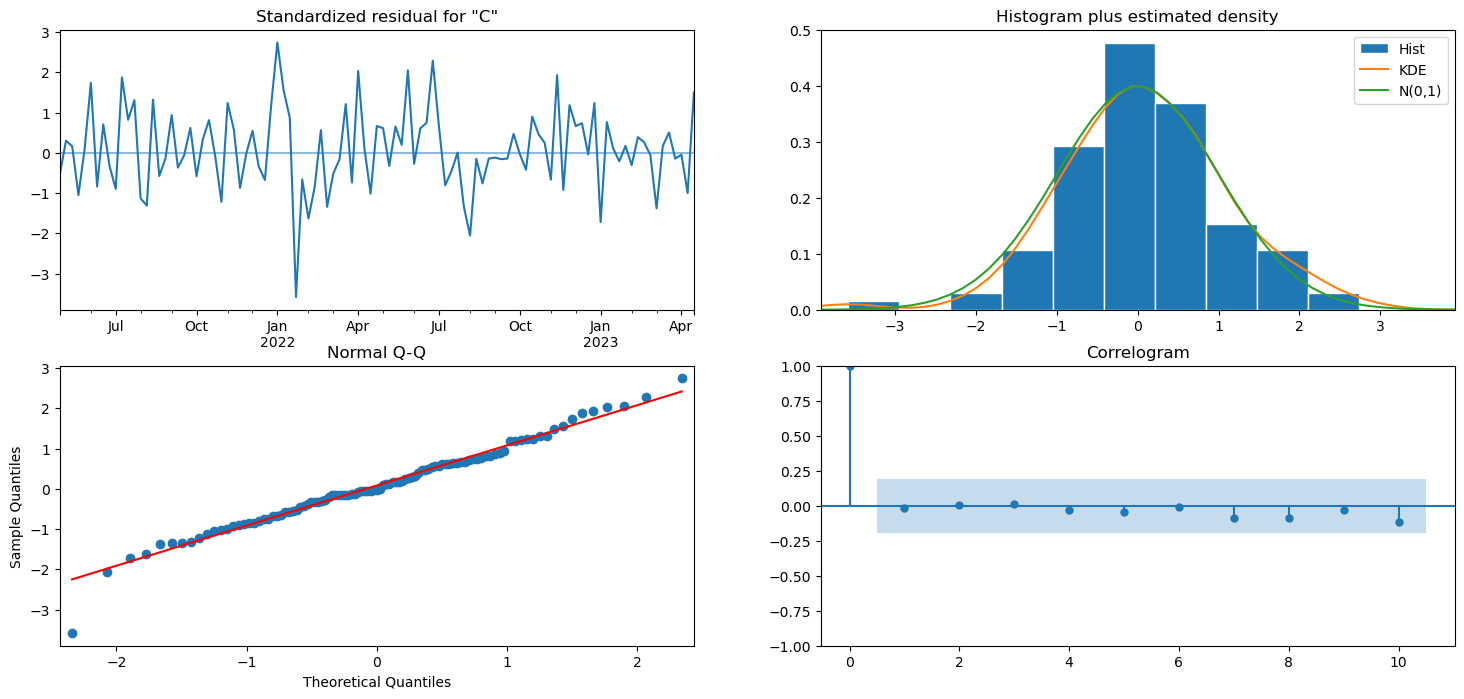

In [34]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from matplotlib import pyplot as plt
import plotly.graph_objects as go

def cargar_datos_cluster(ruta_csv, cluster_id):
    # Leer el archivo CSV
    df = pd.read_csv(ruta_csv)
    
    # Configurar la primera columna ('Cluster') como índice
    df.set_index('Cluster', inplace=True)
    
    # Transponer el dataframe para que las fechas sean el índice
    df = df.transpose()
    
    # Filtrar los datos para el cluster específico
    cluster_data = df[cluster_id]
    
    # Resetear el índice para que las fechas sean una columna y no el índice
    cluster_data = cluster_data.reset_index()
    
    # Cambiar los nombres de las columnas
    cluster_data.columns = ['Fecha', 'Contagios']
    
    # Convertir la columna de fecha a tipo datetime para manejarlo como serie temporal
    cluster_data['Fecha'] = pd.to_datetime(cluster_data['Fecha'], format='%d-%m-%Y')
    
    # Establecer la fecha como índice
    cluster_data.set_index('Fecha', inplace=True)
    
    return cluster_data


# Ruta del archivo CSV
ruta_csv = 'clusterSemanal.csv'
# ID del cluster que el usuario quiere explorar
cluster_id = 2

# Cargar los datos
df_pacientesRespiratorios = cargar_datos_cluster(ruta_csv, cluster_id)

# Asegurarse de que no hay valores no positivos antes de la transformación Box-Cox
df_pacientesRespiratorios['Contagios'] = df_pacientesRespiratorios['Contagios'].clip(lower=1)

# Aplicar transformación Box-Cox
df_pacientesRespiratorios['Contagios_transformed'], lambda_ = boxcox(df_pacientesRespiratorios['Contagios'])

# Dividir los datos transformados en entrenamiento y prueba
train_data_transformed = df_pacientesRespiratorios['Contagios_transformed'].iloc[:-10]
test_data = df_pacientesRespiratorios.iloc[-10:]

p = 2
d = 2
q = 6
P = 1
D = 1
Q = 1
S = 30  # asumiendo una estacionalidad semanal

# Ajuste del modelo SARIMA con los datos de entrenamiento transformados
model = SARIMAX(train_data_transformed,
                order=(p, d, q),
                seasonal_order=(P, D, Q, S),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Diagnósticos del modelo y resultados de resumen
print(results.summary())
results.plot_diagnostics(figsize=(18, 8))
plt.show()

# Hacer predicciones para el conjunto de prueba y revertir la transformación Box-Cox
pred_uc = results.get_forecast(steps=10)
predicted_mean_transformed = pred_uc.predicted_mean
predicted_mean = inv_boxcox(predicted_mean_transformed, lambda_)
predicted_mean.index = test_data.index  # Asignar directamente el índice del conjunto de prueba
pred_ci_transformed = pred_uc.conf_int()
pred_ci = pd.DataFrame()
pred_ci['lower'] = inv_boxcox(pred_ci_transformed.iloc[:, 0], lambda_)
pred_ci['upper'] = inv_boxcox(pred_ci_transformed.iloc[:, 1], lambda_)



# Calcular el error absoluto
error_absoluto = abs(test_data['Contagios'] - predicted_mean)

fig = go.Figure()

# Agregar los datos observados como una serie de líneas con puntos
fig.add_trace(go.Scatter(x=df_pacientesRespiratorios.index, y=df_pacientesRespiratorios['Contagios'], mode='lines+markers', name='Observado'))

# Agregar las predicciones como otra serie de líneas con puntos
fig.add_trace(go.Scatter(x=predicted_mean.index, y=predicted_mean, mode='lines+markers', name='Pronóstico'))

# Agregar el intervalo de confianza como un área sombreada
fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 0], fill=None, mode='lines', line=dict(color='lightgrey'), showlegend=False))
fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 1], fill='tonexty', mode='lines', line=dict(color='lightgrey'), showlegend=False))

# Agregar los datos reales de prueba como una línea discontinua con puntos
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Contagios'], mode='lines+markers', name='Real', line=dict(dash='dash')))

# Agregar el error absoluto como una nueva serie de barras
fig.add_trace(go.Bar(x=test_data.index, y=error_absoluto, name='Error Absoluto'))

# Actualizar el diseño de la gráfica para añadir títulos y etiquetas
fig.update_layout(title='Contagios Observados, Pronósticos y Error Absoluto',
                  xaxis_title='Fecha',
                  yaxis_title='Contagios',
                  legend_title='Leyenda')

# Mostrar la figura
fig.show()

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63304D+00    |proj g|=  1.36135D-01

At iterate    5    f=  1.51924D+00    |proj g|=  7.86663D-02

At iterate   10    f=  1.49443D+00    |proj g|=  3.74815D-01

At iterate   15    f=  1.48549D+00    |proj g|=  8.37307D-02

At iterate   20    f=  1.47294D+00    |proj g|=  3.45978D-02

At iterate   25    f=  1.47148D+00    |proj g|=  1.45544D-01

At iterate   30    f=  1.47085D+00    |proj g|=  2.30303D-02

At iterate   35    f=  1.47048D+00    |proj g|=  1.62194D-02

At iterate   40    f=  1.46978D+00    |proj g|=  1.25827D-02

At iterate   45    f=  1.46964D+00    |proj g|=  3.47676D-02

At iterate   50    f=  1.46908D+00    |proj g|=  2.65871D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                       
Dep. Variable:                Contagios_transformed   No. Observations:                  172
Model:             SARIMAX(1, 3, 5)x(1, 1, [1], 30)   Log Likelihood                -252.682
Date:                              Thu, 18 Apr 2024   AIC                            523.364
Time:                                      15:52:35   BIC                            547.076
Sample:                                  01-05-2020   HQIC                           532.968
                                       - 04-16-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5867      0.315     -1.862      0.063      -1.204       0.031
ma.L1         -0.95

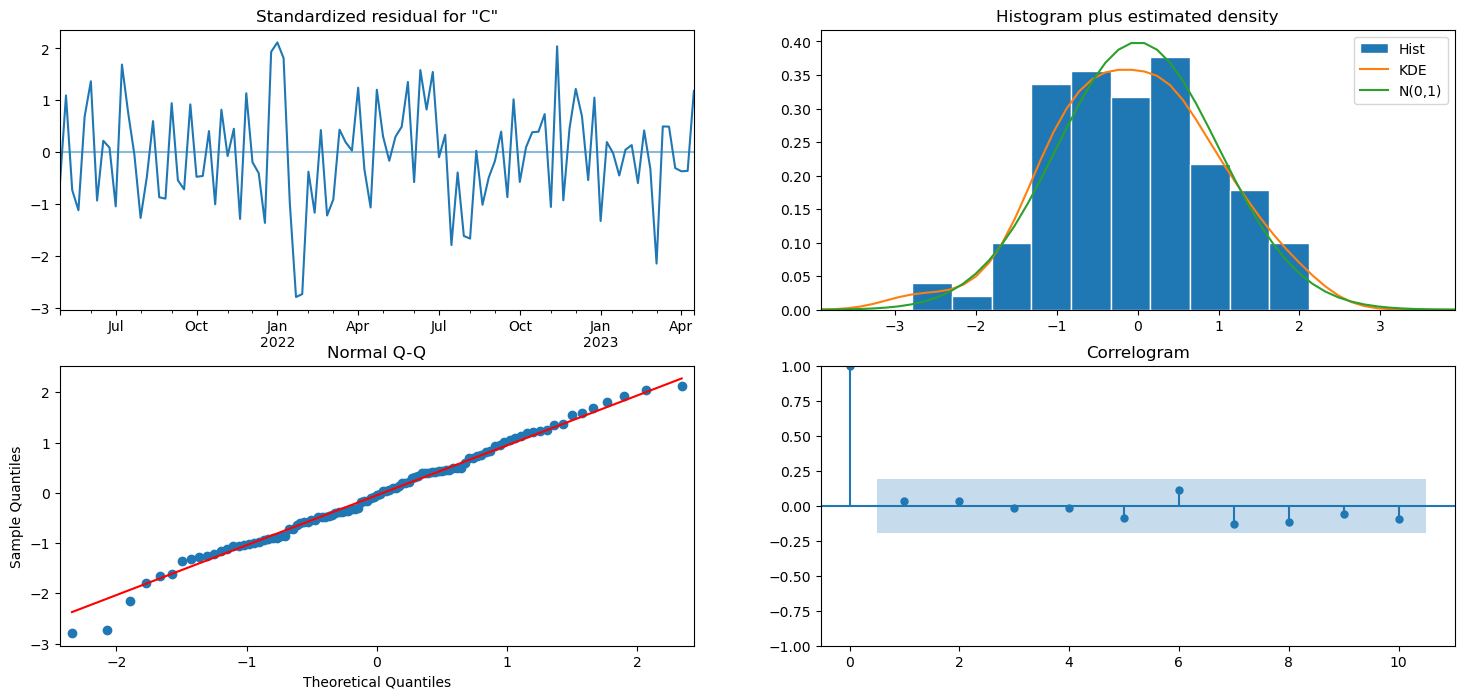

In [45]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from matplotlib import pyplot as plt
import plotly.graph_objects as go

def cargar_datos_cluster(ruta_csv, cluster_id):
    # Leer el archivo CSV
    df = pd.read_csv(ruta_csv)
    
    # Configurar la primera columna ('Cluster') como índice
    df.set_index('Cluster', inplace=True)
    
    # Transponer el dataframe para que las fechas sean el índice
    df = df.transpose()
    
    # Filtrar los datos para el cluster específico
    cluster_data = df[cluster_id]
    
    # Resetear el índice para que las fechas sean una columna y no el índice
    cluster_data = cluster_data.reset_index()
    
    # Cambiar los nombres de las columnas
    cluster_data.columns = ['Fecha', 'Contagios']
    
    # Convertir la columna de fecha a tipo datetime para manejarlo como serie temporal
    cluster_data['Fecha'] = pd.to_datetime(cluster_data['Fecha'], format='%d-%m-%Y')
    
    # Establecer la fecha como índice
    cluster_data.set_index('Fecha', inplace=True)
    
    return cluster_data


# Ruta del archivo CSV
ruta_csv = 'clusterSemanal.csv'
# ID del cluster que el usuario quiere explorar
cluster_id = 3

# Cargar los datos
df_pacientesRespiratorios = cargar_datos_cluster(ruta_csv, cluster_id)

# Asegurarse de que no hay valores no positivos antes de la transformación Box-Cox
df_pacientesRespiratorios['Contagios'] = df_pacientesRespiratorios['Contagios'].clip(lower=1)

# Aplicar transformación Box-Cox
df_pacientesRespiratorios['Contagios_transformed'], lambda_ = boxcox(df_pacientesRespiratorios['Contagios'])

# Dividir los datos transformados en entrenamiento y prueba
train_data_transformed = df_pacientesRespiratorios['Contagios_transformed'].iloc[:-10]
test_data = df_pacientesRespiratorios.iloc[-10:]

p = 1
d = 3
q = 5
P = 1
D = 1
Q = 1
S = 30  # asumiendo una estacionalidad semanal

# Ajuste del modelo SARIMA con los datos de entrenamiento transformados
model = SARIMAX(train_data_transformed,
                order=(p, d, q),
                seasonal_order=(P, D, Q, S),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Diagnósticos del modelo y resultados de resumen
print(results.summary())
results.plot_diagnostics(figsize=(18, 8))
plt.show()

# Hacer predicciones para el conjunto de prueba y revertir la transformación Box-Cox
pred_uc = results.get_forecast(steps=10)
predicted_mean_transformed = pred_uc.predicted_mean
predicted_mean = inv_boxcox(predicted_mean_transformed, lambda_)
predicted_mean.index = test_data.index  # Asignar directamente el índice del conjunto de prueba
pred_ci_transformed = pred_uc.conf_int()
pred_ci = pd.DataFrame()
pred_ci['lower'] = inv_boxcox(pred_ci_transformed.iloc[:, 0], lambda_)
pred_ci['upper'] = inv_boxcox(pred_ci_transformed.iloc[:, 1], lambda_)



# Calcular el error absoluto
error_absoluto = abs(test_data['Contagios'] - predicted_mean)

fig = go.Figure()

# Agregar los datos observados como una serie de líneas con puntos
fig.add_trace(go.Scatter(x=df_pacientesRespiratorios.index, y=df_pacientesRespiratorios['Contagios'], mode='lines+markers', name='Observado'))

# Agregar las predicciones como otra serie de líneas con puntos
fig.add_trace(go.Scatter(x=predicted_mean.index, y=predicted_mean, mode='lines+markers', name='Pronóstico'))

# Agregar el intervalo de confianza como un área sombreada
fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 0], fill=None, mode='lines', line=dict(color='lightgrey'), showlegend=False))
fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 1], fill='tonexty', mode='lines', line=dict(color='lightgrey'), showlegend=False))

# Agregar los datos reales de prueba como una línea discontinua con puntos
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Contagios'], mode='lines+markers', name='Real', line=dict(dash='dash')))

# Agregar el error absoluto como una nueva serie de barras
fig.add_trace(go.Bar(x=test_data.index, y=error_absoluto, name='Error Absoluto'))

# Actualizar el diseño de la gráfica para añadir títulos y etiquetas
fig.update_layout(title='Contagios Observados, Pronósticos y Error Absoluto',
                  xaxis_title='Fecha',
                  yaxis_title='Contagios',
                  legend_title='Leyenda')

# Mostrar la figura
fig.show()

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/home/rodrigo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51564D+00    |proj g|=  1.59883D-01


 This problem is unconstrained.



At iterate    5    f=  1.47197D+00    |proj g|=  5.77975D-02

At iterate   10    f=  1.46734D+00    |proj g|=  3.11472D-03

At iterate   15    f=  1.46731D+00    |proj g|=  1.11153D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     22      1     0     0   3.351D-05   1.467D+00
  F =   1.4673118787096084     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                      SARIMAX Results                                       
Dep. Variable:                Contagios_transformed   No. Observations:                  172
Model:             SARIMAX(1, 1, 3)x(1, 1, [1], 30)

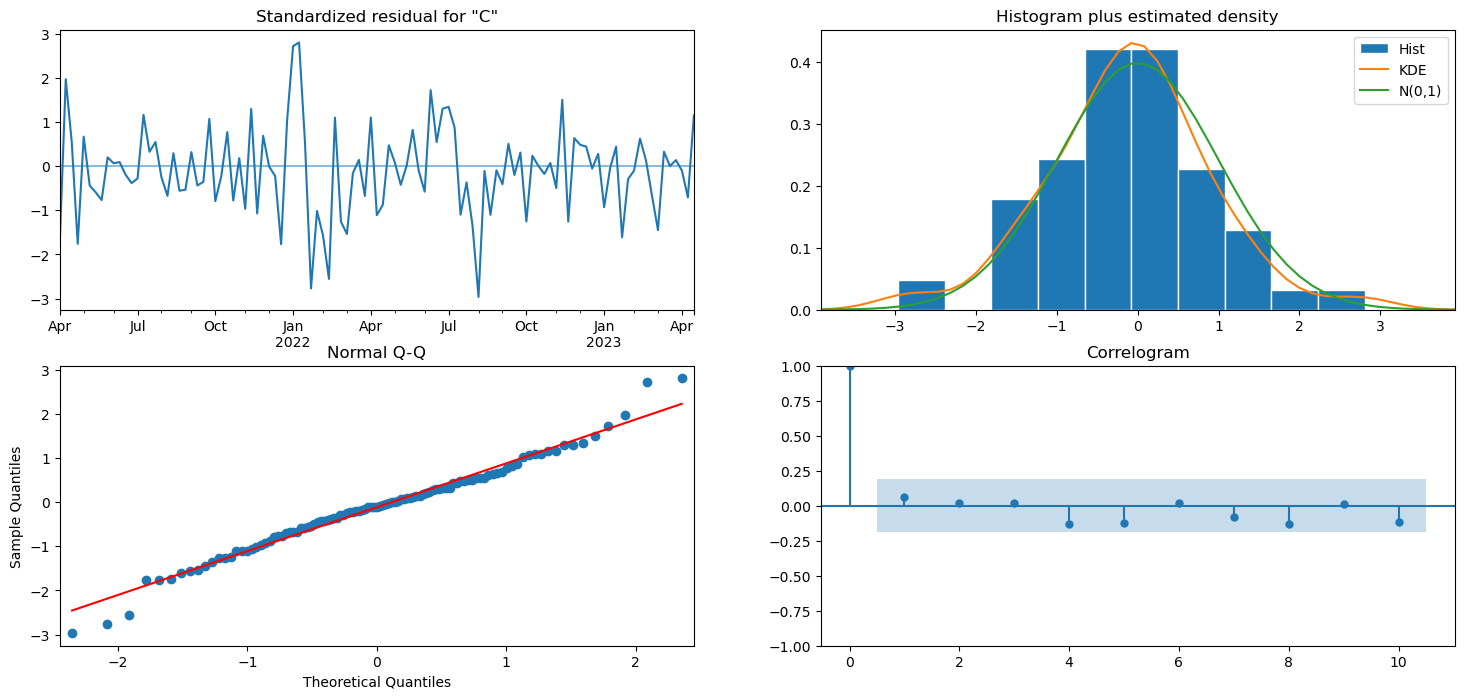

In [6]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from matplotlib import pyplot as plt
import plotly.graph_objects as go

def cargar_datos_cluster(ruta_csv, cluster_id):
    # Leer el archivo CSV
    df = pd.read_csv(ruta_csv)
    
    # Configurar la primera columna ('Cluster') como índice
    df.set_index('Cluster', inplace=True)
    
    # Transponer el dataframe para que las fechas sean el índice
    df = df.transpose()
    
    # Filtrar los datos para el cluster específico
    cluster_data = df[cluster_id]
    
    # Resetear el índice para que las fechas sean una columna y no el índice
    cluster_data = cluster_data.reset_index()
    
    # Cambiar los nombres de las columnas
    cluster_data.columns = ['Fecha', 'Contagios']
    
    # Convertir la columna de fecha a tipo datetime para manejarlo como serie temporal
    cluster_data['Fecha'] = pd.to_datetime(cluster_data['Fecha'], format='%d-%m-%Y')
    
    # Establecer la fecha como índice
    cluster_data.set_index('Fecha', inplace=True)
    
    return cluster_data


# Ruta del archivo CSV
ruta_csv = 'clusterSemanal.csv'
# ID del cluster que el usuario quiere explorar
cluster_id = 4

# Cargar los datos
df_pacientesRespiratorios = cargar_datos_cluster(ruta_csv, cluster_id)

# Asegurarse de que no hay valores no positivos antes de la transformación Box-Cox
df_pacientesRespiratorios['Contagios'] = df_pacientesRespiratorios['Contagios'].clip(lower=1)

# Aplicar transformación Box-Cox
df_pacientesRespiratorios['Contagios_transformed'], lambda_ = boxcox(df_pacientesRespiratorios['Contagios'])

# Dividir los datos transformados en entrenamiento y prueba
train_data_transformed = df_pacientesRespiratorios['Contagios_transformed'].iloc[:-10]
test_data = df_pacientesRespiratorios.iloc[-10:]

p = 1
d = 1
q = 3
P = 1
D = 1
Q = 1
S = 30  # asumiendo una estacionalidad semanal

# Ajuste del modelo SARIMA con los datos de entrenamiento transformados
model = SARIMAX(train_data_transformed,
                order=(p, d, q),
                seasonal_order=(P, D, Q, S),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Diagnósticos del modelo y resultados de resumen
print(results.summary())
results.plot_diagnostics(figsize=(18, 8))
plt.show()

# Hacer predicciones para el conjunto de prueba y revertir la transformación Box-Cox
pred_uc = results.get_forecast(steps=10)
predicted_mean_transformed = pred_uc.predicted_mean
predicted_mean = inv_boxcox(predicted_mean_transformed, lambda_)
predicted_mean.index = test_data.index  # Asignar directamente el índice del conjunto de prueba
pred_ci_transformed = pred_uc.conf_int()
pred_ci = pd.DataFrame()
pred_ci['lower'] = inv_boxcox(pred_ci_transformed.iloc[:, 0], lambda_)
pred_ci['upper'] = inv_boxcox(pred_ci_transformed.iloc[:, 1], lambda_)



# Calcular el error absoluto
error_absoluto = abs(test_data['Contagios'] - predicted_mean)

fig = go.Figure()

# Agregar los datos observados como una serie de líneas con puntos
fig.add_trace(go.Scatter(x=df_pacientesRespiratorios.index, y=df_pacientesRespiratorios['Contagios'], mode='lines+markers', name='Observado'))

# Agregar las predicciones como otra serie de líneas con puntos
fig.add_trace(go.Scatter(x=predicted_mean.index, y=predicted_mean, mode='lines+markers', name='Pronóstico'))

# Agregar el intervalo de confianza como un área sombreada
fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 0], fill=None, mode='lines', line=dict(color='lightgrey'), showlegend=False))
fig.add_trace(go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 1], fill='tonexty', mode='lines', line=dict(color='lightgrey'), showlegend=False))

# Agregar los datos reales de prueba como una línea discontinua con puntos
fig.add_trace(go.Scatter(x=test_data.index, y=test_data['Contagios'], mode='lines+markers', name='Real', line=dict(dash='dash')))

# Agregar el error absoluto como una nueva serie de barras
fig.add_trace(go.Bar(x=test_data.index, y=error_absoluto, name='Error Absoluto'))

# Actualizar el diseño de la gráfica para añadir títulos y etiquetas
fig.update_layout(title='Contagios Observados, Pronósticos y Error Absoluto',
                  xaxis_title='Fecha',
                  yaxis_title='Contagios',
                  legend_title='Leyenda')

# Mostrar la figura
fig.show()